In [1]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd


class MyARIMA:
    sc_in = MinMaxScaler(feature_range=(0, 1))
    sc_out = MinMaxScaler(feature_range=(0, 1))

    def __init__(self, args):
        self.train_size = -1
        self.test_size = -1
        self.order = tuple(map(int, args.order.split(', ')))

    def fit(self, data_x):
        data_x = np.array(data_x)
        train_x = data_x[:, 1:-1]  # Exclude the 'Date' and 'Next_Close' column
        train_y = data_x[:, -1] 
        print(train_x)
        self.train_size = train_x.shape[0]
        train_x = self.sc_in.fit_transform(train_x)
        train_y = train_y.reshape(-1, 1)
        train_y = self.sc_out.fit_transform(train_y)
        train_x = np.array(train_x, dtype=float)
        train_y = np.array(train_y, dtype=float).flatten()
        self.model = ARIMA(train_y,
                             exog=train_x,
                             order=self.order)
        self.result = self.model.fit()

    def predict(self, test_x):
        # Ensure we are only using the same features that were used for training
        test_x = np.array(test_x[["Open", "High", "Low", "Volume"]], dtype=float)
        test_x = self.sc_in.transform(test_x)  # Scale the test features
        
        # Predict using the model
        pred_y = self.result.predict(start=self.train_size, end=self.train_size + test_x.shape[0] - 1, exog=test_x)
        
        # Reshape and inverse transform the predictions to get them back to the original scale
        pred_y = pred_y.reshape(-1, 1)
        pred_y = self.sc_out.inverse_transform(pred_y)
        return pred_y


In [2]:
import yfinance as yf

# Download stock data for a given symbol, e.g., 'AAPL'
data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')

# Reset the index to make the 'Date' column a regular column
data.reset_index(inplace=True)

# View the first few rows
print(data.head())


[*********************100%***********************]  1 of 1 completed

        Date       Open       High        Low      Close  Adj Close     Volume
0 2020-01-02  74.059998  75.150002  73.797501  75.087502  72.876106  135480400
1 2020-01-03  74.287498  75.144997  74.125000  74.357498  72.167610  146322800
2 2020-01-06  73.447502  74.989998  73.187500  74.949997  72.742653  118387200
3 2020-01-07  74.959999  75.224998  74.370003  74.597504  72.400551  108872000
4 2020-01-08  74.290001  76.110001  74.290001  75.797501  73.565186  132079200


In [3]:
# Prepare the data for ARIMA model (we predict 'Close' price using other features)
# Let's use 'Open', 'High', 'Low', 'Volume' as features

data['Next_Close'] = data['Close'].shift(-1)  # Create a target column (predict next day's close)

# Drop the last row since it will have NaN in 'Next_Close'
data.dropna(inplace=True)

# Select features and target
features = ['Open', 'High', 'Low', 'Volume']  # Features for prediction
target = ['Next_Close']  # Target variable (next day's close price)

# Concatenate 'Date', features and target for input to MyARIMA class
input_data = pd.concat([data['Date'], data[features], data[target]], axis=1)


In [4]:
args = type('', (), {})()  # Create a dummy object to hold arguments
args.order = '1, 0, 1'  # ARIMA(p,d,q) order, adjust as needed

# Initialize MyARIMA class
model = MyARIMA(args)

# Fit the model on historical data (ignore the first column 'Date')
model.fit(input_data)


[[74.05999755859375 75.1500015258789 73.79750061035156 135480400]
 [74.2874984741211 75.1449966430664 74.125 146322800]
 [73.44750213623047 74.98999786376953 73.1875 118387200]
 ...
 [131.3800048828125 131.41000366210938 128.72000122070312 69007800]
 [129.6699981689453 131.02999877929688 125.87000274658203 85438400]
 [127.98999786376953 130.47999572753906 127.7300033569336 75703700]]


In [5]:
# Prepare test data (let's predict for the last 5 days as an example)
test_data = data.iloc[-10:]  # Select last 5 rows for testing
print(test_data)
predictions = model.predict(test_data)

# Print predictions
print("Predicted Close Prices:", predictions)


          Date        Open        High         Low       Close   Adj Close  \
745 2022-12-15  141.110001  141.800003  136.029999  136.500000  135.228119   
746 2022-12-16  136.690002  137.649994  133.729996  134.509995  133.256653   
747 2022-12-19  135.110001  135.199997  131.320007  132.369995  131.136627   
748 2022-12-20  131.389999  133.250000  129.889999  132.300003  131.067261   
749 2022-12-21  132.979996  136.809998  132.750000  135.449997  134.187897   
750 2022-12-22  134.350006  134.559998  130.300003  132.229996  130.997894   
751 2022-12-23  130.919998  132.419998  129.639999  131.860001  130.631363   
752 2022-12-27  131.380005  131.410004  128.720001  130.029999  128.818420   
753 2022-12-28  129.669998  131.029999  125.870003  126.040001  124.865601   
754 2022-12-29  127.989998  130.479996  127.730003  129.610001  128.402344   

        Volume  Next_Close  
745   98931900  134.509995  
746  160156900  132.369995  
747   79592600  132.300003  
748   77432800  135.44999

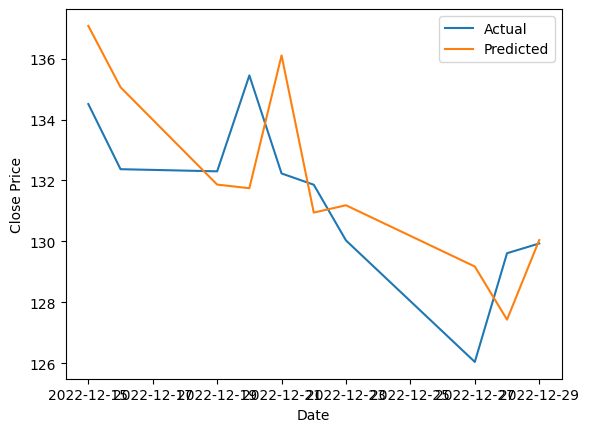

In [6]:
import matplotlib.pyplot as plt

# Plot actual vs predicted
plt.plot(data['Date'][-10:], test_data['Next_Close'], label='Actual')
plt.plot(data['Date'][-10:], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
